In [1]:
# !pip install pycaret
# !pip install pycaret[tuners]

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
import pickle
from pycaret.classification import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from utils import *
import numpy as np

%matplotlib inline

In [3]:
# GLOBAL VAR
PATH = './'

In [4]:
df = pd.read_csv(PATH+'data_training.csv')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,140000,2,2.0,2,35,0,0,0,0,0,...,93606.0,95301.0,96653.0,3280.0,4270.0,3500.0,3606.0,3500.0,3550.0,0
1,40000,2,3.0,1,24,1,8,7,6,5,...,24579.0,23635.0,22680.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,50000,1,3.0,1,51,-1,-1,-1,-1,-1,...,8500.0,0.0,0.0,13902.0,42863.0,8500.0,0.0,0.0,0.0,0
3,90000,2,1.0,2,29,-1,-1,-1,-1,0,...,3199.0,1888.0,0.0,6198.0,200.0,3199.0,0.0,0.0,0.0,0
4,50000,1,2.0,3,52,0,0,0,0,0,...,10683.0,9953.0,9567.0,2500.0,1500.0,1300.0,800.0,1000.0,1500.0,0


# Data Processing Pipeline

In [5]:
cust_pipeline = Pipeline([
    ( 'GenerateMissingIndicator: EDUCATION', GenerateMissingIndicator(['EDUCATION']) ),
    ( 'GroupRareLevels: EDUCATION, MARRIAGE', GroupRareLevels(feat_lst=['EDUCATION', 'MARRIAGE']) ),
    ( 'OutlierRemovalIQR: AGE, LIMIT_BAL', OutlierRemovalIQR(['AGE', 'LIMIT_BAL']) )
])

---- GenerateMissingIndicator init method ----
Features : ['EDUCATION']
---- GroupRareLevels init method ----
0.01
---- OutlierRemovalIQR init method ----
Features : {'AGE': [], 'LIMIT_BAL': []}


In [6]:
df_new = cust_pipeline.fit_transform(df)

---- GenerateMissingIndicator fit method ----
---- GenerateMissingIndicator transform method ----
---- GroupRareLevels fit method ----
EDUCATION
{2.0: 0.4681585276586845, 1.0: 0.3527658684513228, 3.0: 0.16354700407821812, 5.0: 0.009202133221792325, 4.0: 0.004025933284534142, 6.0: 0.001882254522639339, 0.0: 0.00041827878280874205}
MARRIAGE
{2: 0.53265625, 1: 0.455, 3: 0.010625, 0: 0.00171875}
Features : {'EDUCATION': [5.0, 4.0, 6.0, 0.0], 'MARRIAGE': [0]}
---- GroupRareLevels transform method ----
---- OutlierRemovalIQR fit method ----
Features : {'AGE': [8.5, 60.5], 'LIMIT_BAL': [-235000.0, 525000.0]}
---- OutlierRemovalIQR transform method ----


In [7]:
# Save custom pipeline
filename = PATH+'cust_pipe.pkl'
with open(filename, "wb") as f:
    pickle.dump(cust_pipeline, f)

### How well are we doing?

In [8]:
df_new['EDUCATION'].value_counts(normalize=True)

2.0      0.470295
1.0      0.352695
3.0      0.161415
other    0.015595
Name: EDUCATION, dtype: float64

In [9]:
df_new['MARRIAGE'].value_counts(normalize=True)

2        0.536649
1        0.451038
3        0.010569
other    0.001744
Name: MARRIAGE, dtype: float64

<Axes: >

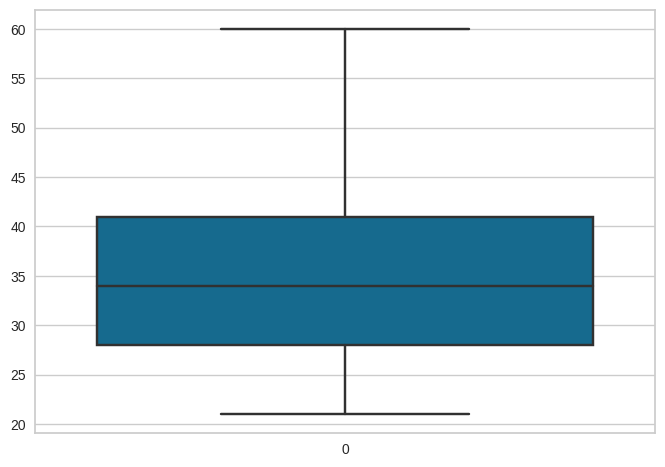

In [10]:
sns.boxplot(df_new['AGE'])

<Axes: >

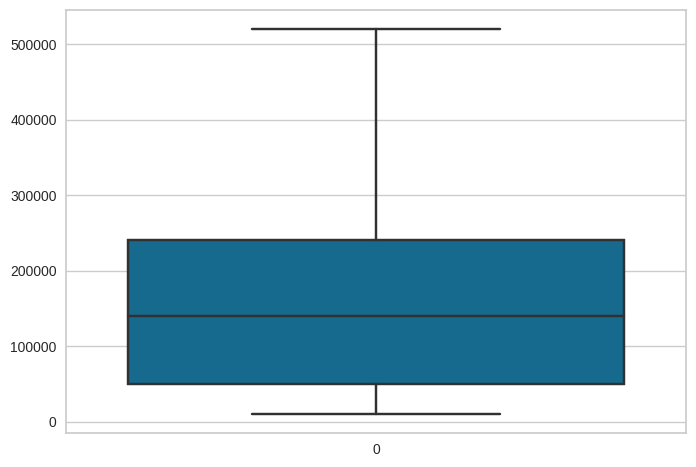

In [11]:
sns.boxplot(df_new['LIMIT_BAL'])

In [12]:
df_new.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default',
       'EDUCATION_missing'],
      dtype='object')

# Let's train some models

In [13]:
clf_exp = setup(
    data = df_new,
    target='default',
    fold=5,
    normalize=True,
    transformation=True,
    ignore_features=['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
    # log_experiment = True, experiment_name = 'baseline'
)

,Description,Value
0,Session id,302
1,Target,default
2,Target type,Binary
3,Original data shape,"(18923, 25)"
4,Transformed data shape,"(18923, 19)"
5,Transformed train set shape,"(13246, 19)"
6,Transformed test set shape,"(5677, 19)"
7,Ignore features,12
8,Numeric features,10
9,Categorical features,2


In [14]:
?get_config

In [15]:
get_config('pipeline').steps

[('numerical_imputer',
  TransformerWrapper(exclude=None,
                     include=['LIMIT_BAL', 'SEX', 'AGE', 'PAY_1', 'PAY_2',
                              'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                              'EDUCATION_missing'],
                     transformer=SimpleImputer(add_indicator=False, copy=True,
                                               fill_value=None,
                                               keep_empty_features=False,
                                               missing_values=nan,
                                               strategy='mean',
                                               verbose='deprecated'))),
 ('categorical_imputer',
  TransformerWrapper(exclude=None, include=['EDUCATION', 'MARRIAGE'],
                     transformer=SimpleImputer(add_indicator=False, copy=True,
                                               fill_value=None,
                                               keep_empty_features=False,
                 

### What all these transformations give us?

<Axes: >

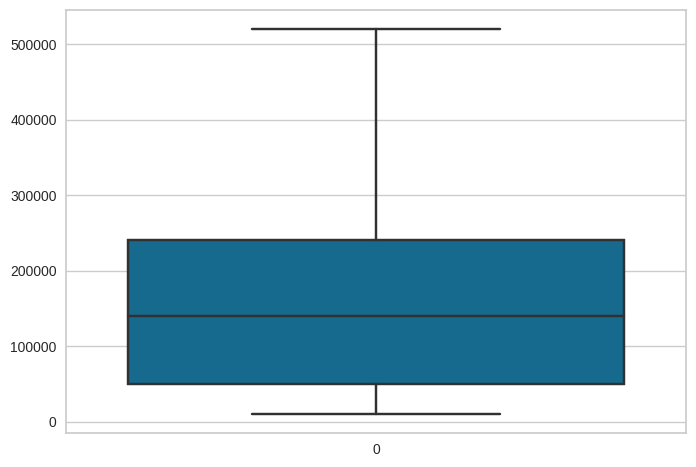

In [16]:
sns.boxplot(get_config('X')['LIMIT_BAL'])

<Axes: xlabel='LIMIT_BAL', ylabel='Density'>

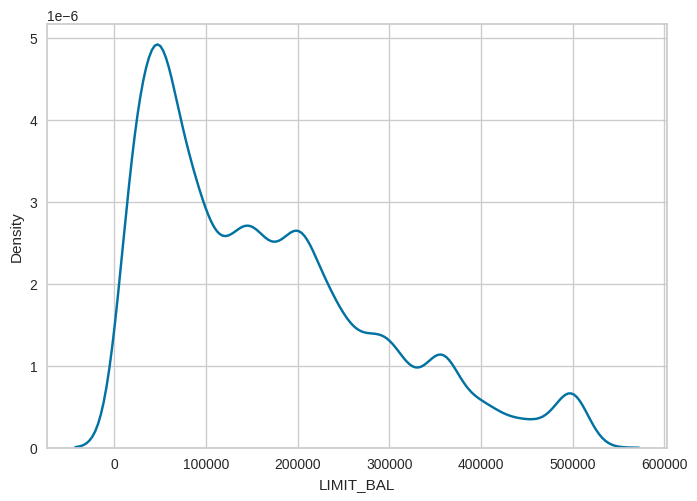

In [17]:
sns.kdeplot(get_config('X')['LIMIT_BAL'])

In [18]:
get_config('X').columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_missing'],
      dtype='object')

### OK - lets look at models

In [19]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [20]:
dummy = create_model('dummy', constant=0)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7789,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7788,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7788,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7788,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7788,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.7788,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
Std,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8023,0.7029,0.1945,0.6867,0.3032,0.2278,0.2900
1,0.7958,0.7131,0.1348,0.6991,0.2260,0.1664,0.2430
2,0.8018,0.7463,0.1519,0.7607,0.2532,0.1938,0.2794
3,0.8052,0.7127,0.1826,0.7431,0.2932,0.2256,0.3014
4,0.7965,0.6834,0.1843,0.6391,0.2861,0.2076,0.2628
Mean,0.8003,0.7117,0.1696,0.7057,0.2723,0.2042,0.2753
Std,0.0036,0.0204,0.0225,0.0430,0.0286,0.0226,0.0206


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=302, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# can we do better?
lr_tuned = tune_model(lr, optimize='F1', search_library='scikit-optimize')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6551,0.7028,0.6314,0.3464,0.4474,0.2265,0.2481
1,0.6640,0.7144,0.6621,0.3593,0.4658,0.2510,0.2759
2,0.6580,0.7464,0.7167,0.3621,0.4811,0.2651,0.2995
3,0.6406,0.7125,0.6689,0.3409,0.4516,0.2243,0.2525
4,0.6467,0.6827,0.6280,0.3389,0.4402,0.2144,0.2363
Mean,0.6529,0.7118,0.6614,0.3495,0.4572,0.2362,0.2625
Std,0.0083,0.0206,0.0320,0.0095,0.0146,0.0188,0.0226


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [24]:
lr_tuned

LogisticRegression(C=7.23783976624601, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=302, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
# !mlflow ui -h 0.0.0.0

In [26]:
evaluate_model(lr_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [27]:
lr_df_pred = predict_model(lr_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6558,0.7251,0.6799,0.3549,0.4664,0.2477,0.2763


In [29]:
lr_df_pred

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,EDUCATION_missing,default,prediction_label,prediction_score
15026,310000,2,3.0,2,28,0,0,0,0,0,0,0,0,0,0.6577
8007,20000,1,2.0,1,40,1,2,3,2,3,3,0,0,1,0.7675
1535,190000,2,1.0,2,26,0,0,0,0,0,0,0,1,0,0.5788
3863,170000,2,2.0,2,51,0,-1,-1,-1,-1,-1,0,0,0,0.5829
57,50000,2,2.0,1,42,0,0,0,0,0,0,0,0,1,0.5676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2722,50000,1,3.0,1,32,0,0,0,0,0,0,0,0,1,0.5732
4197,20000,1,2.0,2,25,0,0,0,0,0,0,0,1,1,0.5555
10574,180000,2,1.0,1,37,2,-1,-1,-1,-1,0,0,1,1,0.6838
8045,180000,2,2.0,2,29,0,0,0,2,2,0,0,0,0,0.6009


In [30]:
true_class = lr_df_pred['default']
pred_prob = lr_df_pred['prediction_score']

In [31]:
pred_prob

15026    0.6577
8007     0.7675
1535     0.5788
3863     0.5829
57       0.5676
          ...  
2722     0.5732
4197     0.5555
10574    0.6838
8045     0.6009
10526    0.5398
Name: prediction_score, Length: 5677, dtype: float64

# Expected Utility - what threshold should use in business?

In [34]:
from sklearn.metrics import confusion_matrix

def EU(thresh, benefit_tp=0, benefit_tn=0, benefit_fp=-1000, benefit_fn=-2000):

    pred_class = (pred_prob > thresh) + 0.
    tn, fp, fn, tp = confusion_matrix( true_class, pred_class ).ravel() / pred_class.count()
    EU = benefit_fp * fp + benefit_fn * fn + benefit_tp * tp + benefit_tn * tn

    return EU

EU_vec = np.vectorize(EU)

In [35]:
thresh = np.linspace(0,1,100)
EU_vals = EU_vec(thresh)

thresh_opt= thresh[np.argmax(EU_vals)]
max_EU = max(EU_vals)
min_EU = min(EU_vals)

print('Opt threh = ', thresh_opt)

Opt threh =  0.888888888888889


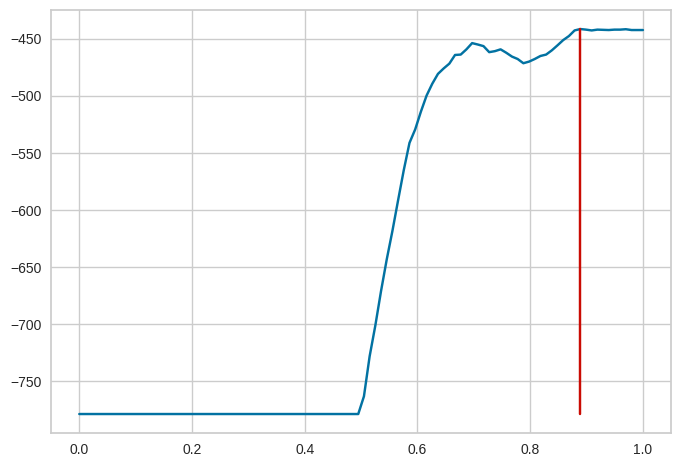

In [36]:
plt.plot(thresh, EU_vals)
plt.plot([thresh_opt, thresh_opt], [min_EU, max_EU], 'r')

# Finalize and Save model

In [38]:
# Finalize model
lr_final = finalize_model(lr_tuned)
save_model(lr_final, PATH+'model_LR')
# save_config(PATH+'pycaret_pipe')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['LIMIT_BAL', 'SEX', 'AGE', 'PAY_1',
                                              'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                              'PAY_6', 'EDUCATION_missing'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbos...
                                     transformer=Stand